In [1]:
%matplotlib notebook
%matplotlib inline

VQA_PATH='/Data_Storage/Rui_Data_Space/multimodal/VQA'
GQA_PATH='/Data_Storage/Rui_Data_Space/multimodal/GQA'

import pandas as pd
from collections import defaultdict

In [2]:
import json
import pickle as pkl

def load_pkl(path):
    data=pkl.load(open(path,'rb'))
    return data

def load_json(path):
    data=json.load(open(path,'r'))
    return data

In [3]:
PATH='/Data_Storage/Rui_Data_Space/textual/hate-speech'

In [4]:
import os
import random

In [5]:
import torch
import requests
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np

In [11]:
def display_img(im,text):
    img = im.convert('RGB')
    img = np.asarray(img, dtype=np.float32).squeeze()
    fig = plt.figure()
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.set_title(text,  fontsize=12)
    ax.imshow(img.astype(np.uint8))    

In [6]:
dataset='mem'
test=load_json(os.path.join(PATH,
                                 'domain_splits',
                                 dataset+'_test.json'))
print (len(test))
train=load_json(os.path.join(PATH,
                                 'domain_splits',
                                 dataset+'_train.json'))
print (len(train))

500
8500


In [32]:
questions=['race','gender','valid_person','valid_animal','country','animal','valid_disable'
          ]
mode='test'
result_files={q:load_pkl(os.path.join(dataset,mode+'_'+q+'.pkl')) for q in questions}
print (len(result_files))

7


In [ ]:
#no all answers are complete sentences
"""ans_mapper={
    'race':'there is a ',
    'gender':'there is a ',
    'country': 'the people come from ',
    'animal': 'there is a '
}"""

In [38]:
generic=load_pkl(os.path.join(dataset,mode+'_generic.pkl'))

<Figure size 432x288 with 0 Axes>

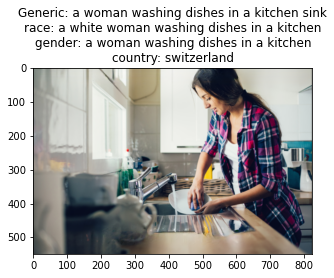

<Figure size 432x288 with 0 Axes>

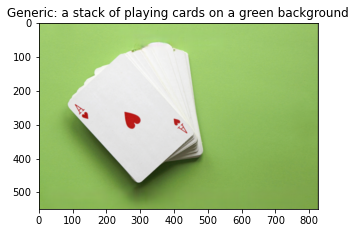

<Figure size 432x288 with 0 Axes>

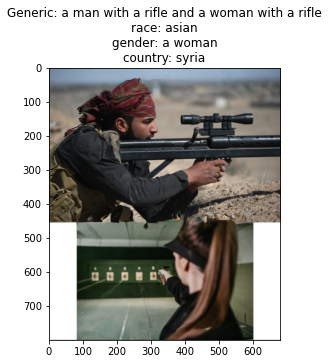

<Figure size 432x288 with 0 Axes>

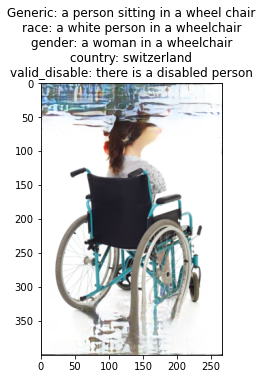

<Figure size 432x288 with 0 Axes>

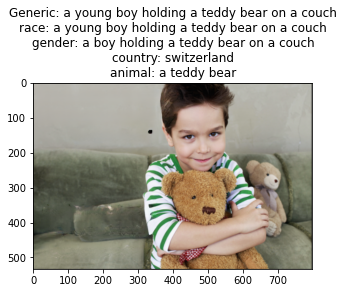

<Figure size 432x288 with 0 Axes>

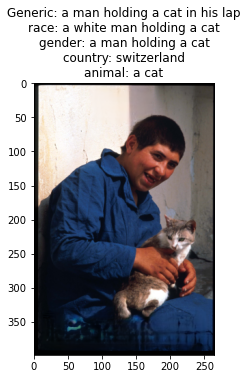

In [47]:
random.shuffle(test)
vis=0
NUM_VIS=5
for row in test:
    if vis>NUM_VIS:
        break
    im=Image.open(os.path.join(PATH,
                               'multimodal-hate',dataset,
                               'img_clean',row['img']))
    text=[]
    text.append('Generic: '+generic[row['img']])
    person_flag=True
    animal_flag=True
    person=result_files['valid_person'][row['img']].lower()
    if person.startswith('no'):
        person_flag=False
    animal=result_files['valid_animal'][row['img']].lower()
    if animal.startswith('no'):
        animal_flag=False
    for q in questions:
        #print ('\t',animal_flag)
        if person_flag==False and q in ['race','gender','country']:
            continue
        if animal_flag==False and q=='animal':
            continue
        if q in ['valid_person','valid_animal']:
            continue
        info=result_files[q][row['img']]
        if q=='valid_disable':
            if info.startswith('no'):
                continue
            else:
                info='there is a disabled person'
        text.append(q+': '+info)
    text='\n'.join(text)
    display_img(im,text)
    vis+=1

In [48]:
from transformers import AutoTokenizer, BertModel
import torch

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")

inputs = tokenizer(["Hello, my dog is cute",
                    "Hello, my dog is cute"], return_tensors="pt")
outputs = model(**inputs)

last_hidden_states = outputs.last_hidden_state

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [51]:
CUDA_DEVICE=7
torch.cuda.set_device(CUDA_DEVICE)
device = torch.device("cuda:"+str(CUDA_DEVICE))

In [52]:
model = BertModel.from_pretrained("bert-base-uncased").to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [97]:
inputs = tokenizer(["Hello, my dog is cute and friendly",
                    "Hello, my dog is cute"], padding='longest', 
                   truncation=True, max_length=20,
                   return_tensors="pt")

In [91]:
print (inputs.keys())

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])


In [98]:
print (inputs.input_ids)

tensor([[  101,  7592,  1010,  2026,  3899,  2003, 10140,  1998,  5379,   102],
        [  101,  7592,  1010,  2026,  3899,  2003, 10140,   102,     0,     0]])


In [101]:
for ids in inputs.input_ids:
    print (ids)
    ids=ids.numpy().tolist()
    print ([ids.index(2026)])

tensor([  101,  7592,  1010,  2026,  3899,  2003, 10140,  1998,  5379,   102])
[3]
tensor([  101,  7592,  1010,  2026,  3899,  2003, 10140,   102,     0,     0])
[3]


In [102]:
a=[3,5,561,353,45634]
b=torch.LongTensor(a)
print (b)
print (b.shape)

tensor([    3,     5,   561,   353, 45634])
torch.Size([5])


In [103]:
a=torch.LongTensor([1,0,0,0,0,1])
b=torch.LongTensor([0,1,0,0,1,0])
c=(a==b).int()
print (c)

tensor([0, 0, 1, 1, 0, 0], dtype=torch.int32)


In [104]:
a=torch.randn(5,2)
b=torch.max(a,1)[1]
print (b)

tensor([0, 0, 1, 1, 1])


In [54]:
last_hidden_states = outputs.last_hidden_state
print (last_hidden_states.shape)

torch.Size([2, 8, 768])


In [64]:
a=torch.randn(3*2,5)
print (a.shape)
print (a)

torch.Size([6, 5])
tensor([[ 0.3806,  0.4658,  0.3282,  0.7547, -2.6066],
        [ 0.9878, -0.1817,  0.8485,  0.7279,  0.9035],
        [ 0.3632,  0.1636,  0.9995, -0.4729,  1.0059],
        [-0.8600, -2.3641,  2.3878,  0.8938,  0.5544],
        [ 1.2517, -0.0097,  0.1063, -0.1570, -0.7308],
        [-0.6155, -2.0352, -0.5124,  0.0983,  0.2050]])


In [65]:
b=a.view(3,2 ,-1)
print (b)

tensor([[[ 0.3806,  0.4658,  0.3282,  0.7547, -2.6066],
         [ 0.9878, -0.1817,  0.8485,  0.7279,  0.9035]],

        [[ 0.3632,  0.1636,  0.9995, -0.4729,  1.0059],
         [-0.8600, -2.3641,  2.3878,  0.8938,  0.5544]],

        [[ 1.2517, -0.0097,  0.1063, -0.1570, -0.7308],
         [-0.6155, -2.0352, -0.5124,  0.0983,  0.2050]]])


In [105]:
a=torch.randn(3,2,5)
b=torch.randn(3,5)

In [106]:
scores = torch.matmul(a,b.unsqueeze(-1))
print (scores.shape)

torch.Size([3, 2, 1])
